# LIBRARIES

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import glob

# DATASET PREPARATION & CONFIGURATION

In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
data_dir = "C:/Users/USER/Downloads/archive/seg_dataset" 
batch_size = 16
num_classes = 3  # CAT, DR, Glaucoma
num_epochs = 25
img_size = 224
learning_rate = 1e-4
patience = 7  # for early stopping

In [7]:
# ImageNet normalization
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# CUSTOM MULTI-CLASS DATASET LOADER

In [13]:
# Custom Dataset for multi-class classification from folder structure
class MultiClassRetinalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['cataract', 'diabetic_retinopathy', 'glaucoma']  
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        self.targets = []
        
        # Load all images from each disease folder
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                # Get all image files (jpg, jpeg, png)
                image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
                for ext in image_extensions:
                    image_files = glob.glob(os.path.join(class_dir, ext))
                    for img_path in image_files:
                        self.samples.append(img_path)
                        self.targets.append(self.class_to_idx[class_name])
        
        print(f"Found {len(self.samples)} images:")
        for i, class_name in enumerate(self.classes):
            count = self.targets.count(i)
            print(f"  {class_name}: {count} images")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.targets[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# DATASET LOADING & SPLITTING

In [15]:
# Load full dataset
full_dataset = MultiClassRetinalDataset(data_dir, transform_val_test)
class_names = full_dataset.classes

# Split dataset into train/val/test (70/15/15)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(total_size), [train_size, val_size, test_size]
)

# Create datasets with appropriate transforms
train_dataset = torch.utils.data.Subset(full_dataset, train_indices.indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices.indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices.indices)

# Apply training transforms to training set
train_data_with_transforms = []
for idx in train_indices.indices:
    img_path = full_dataset.samples[idx]
    label = full_dataset.targets[idx]
    image = Image.open(img_path).convert('RGB')
    image = transform_train(image)
    train_data_with_transforms.append((image, label))

# Create data loaders
train_loader = DataLoader(train_data_with_transforms, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Found 6286 images:
  cataract: 2076 images
  diabetic_retinopathy: 2196 images
  glaucoma: 2014 images


# DATA VISUALIZATION

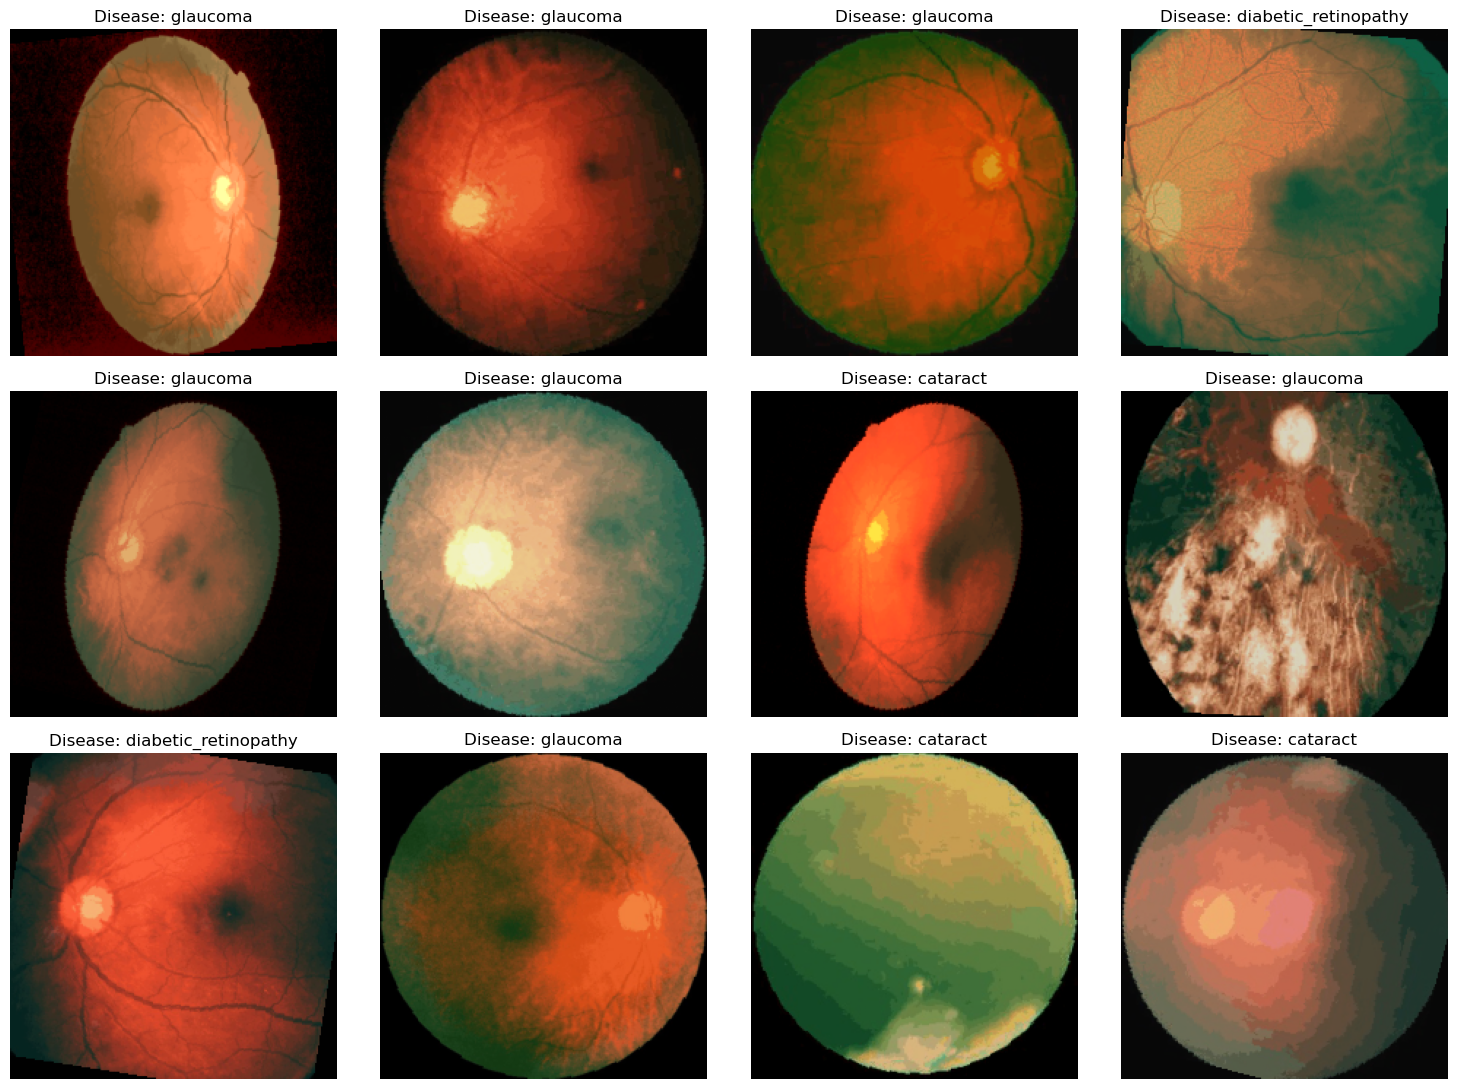

In [16]:
# Display sample images
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(3, 4, figsize=(15, 11))
for i in range(min(12, len(images))):
    img = images[i].permute(1, 2, 0)
    # Denormalize for display
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title(f'Disease: {class_names[labels[i]]}')
    axes[i//4, i%4].axis('off')

# Hide empty subplots
for i in range(len(images), 12):
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()


# MODEL TRAINING & OPTIMIZATION

In [21]:
# Model setup - ResNet50 for multi-class classification
model = models.resnet50(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Multi-class loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training tracking
train_losses = []
val_losses = []
val_accuracies = []

# Early stopping
best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float('inf')
no_improve_epochs = 0

print(f"\n🚀 Starting Training on {device}")
print(f"Total samples: {total_size}")
print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-' * 50)
    
    # --- Training phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    # --- Validation phase ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    
    # Per-class accuracy
    per_class_correct = {i: 0 for i in range(num_classes)}
    per_class_total = {i: 0 for i in range(num_classes)}
    
    for pred, true in zip(all_preds, all_labels):
        per_class_total[true] += 1
        if pred == true:
            per_class_correct[true] += 1
    
    per_class_acc = {i: (per_class_correct[i] / per_class_total[i] * 100) if per_class_total[i] > 0 else 0 
                     for i in range(num_classes)}
    
    print(f"Validation Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Per-class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {per_class_acc[i]:.2f}%")
    
    scheduler.step(avg_val_loss)
    
    # --- Early stopping check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_resnet50_multi_disease_model.pth")
        print("✅ Model improved and saved.")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("⏹️ Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_model_wts)


🚀 Starting Training on cpu
Total samples: 6286
Train: 4400, Val: 942, Test: 944

Epoch 1/25
--------------------------------------------------
Train Loss: 0.3433, Train Acc: 87.64%
Validation Loss: 0.1427, Val Acc: 95.01%
Per-class Accuracy:
  cataract: 94.38%
  diabetic_retinopathy: 98.79%
  glaucoma: 91.44%
✅ Model improved and saved.

Epoch 2/25
--------------------------------------------------
Train Loss: 0.1038, Train Acc: 96.36%
Validation Loss: 0.0922, Val Acc: 96.60%
Per-class Accuracy:
  cataract: 96.25%
  diabetic_retinopathy: 100.00%
  glaucoma: 93.15%
✅ Model improved and saved.

Epoch 3/25
--------------------------------------------------
Train Loss: 0.0525, Train Acc: 98.20%
Validation Loss: 0.0976, Val Acc: 96.28%
Per-class Accuracy:
  cataract: 91.88%
  diabetic_retinopathy: 100.00%
  glaucoma: 96.92%

Epoch 4/25
--------------------------------------------------


KeyboardInterrupt: 

# MODEL EVALUATION & PERFORMANCE ANALYSIS


🎯 FINAL TEST RESULTS
Overall Test Accuracy: 98.52%

Per-class Test Accuracy:
  cataract: 97.52%
  diabetic_retinopathy: 100.00%
  glaucoma: 97.89%

📊 DETAILED CLASSIFICATION REPORT
                      precision    recall  f1-score   support

            cataract     0.9874    0.9752    0.9812       322
diabetic_retinopathy     0.9941    1.0000    0.9971       338
            glaucoma     0.9720    0.9789    0.9754       284

            accuracy                         0.9852       944
           macro avg     0.9845    0.9847    0.9846       944
        weighted avg     0.9852    0.9852    0.9852       944


cataract Detailed Metrics:
  Precision: 0.9874
  Recall: 0.9752
  F1-Score: 0.9812

diabetic_retinopathy Detailed Metrics:
  Precision: 0.9941
  Recall: 1.0000
  F1-Score: 0.9971

glaucoma Detailed Metrics:
  Precision: 0.9720
  Recall: 0.9789
  F1-Score: 0.9754


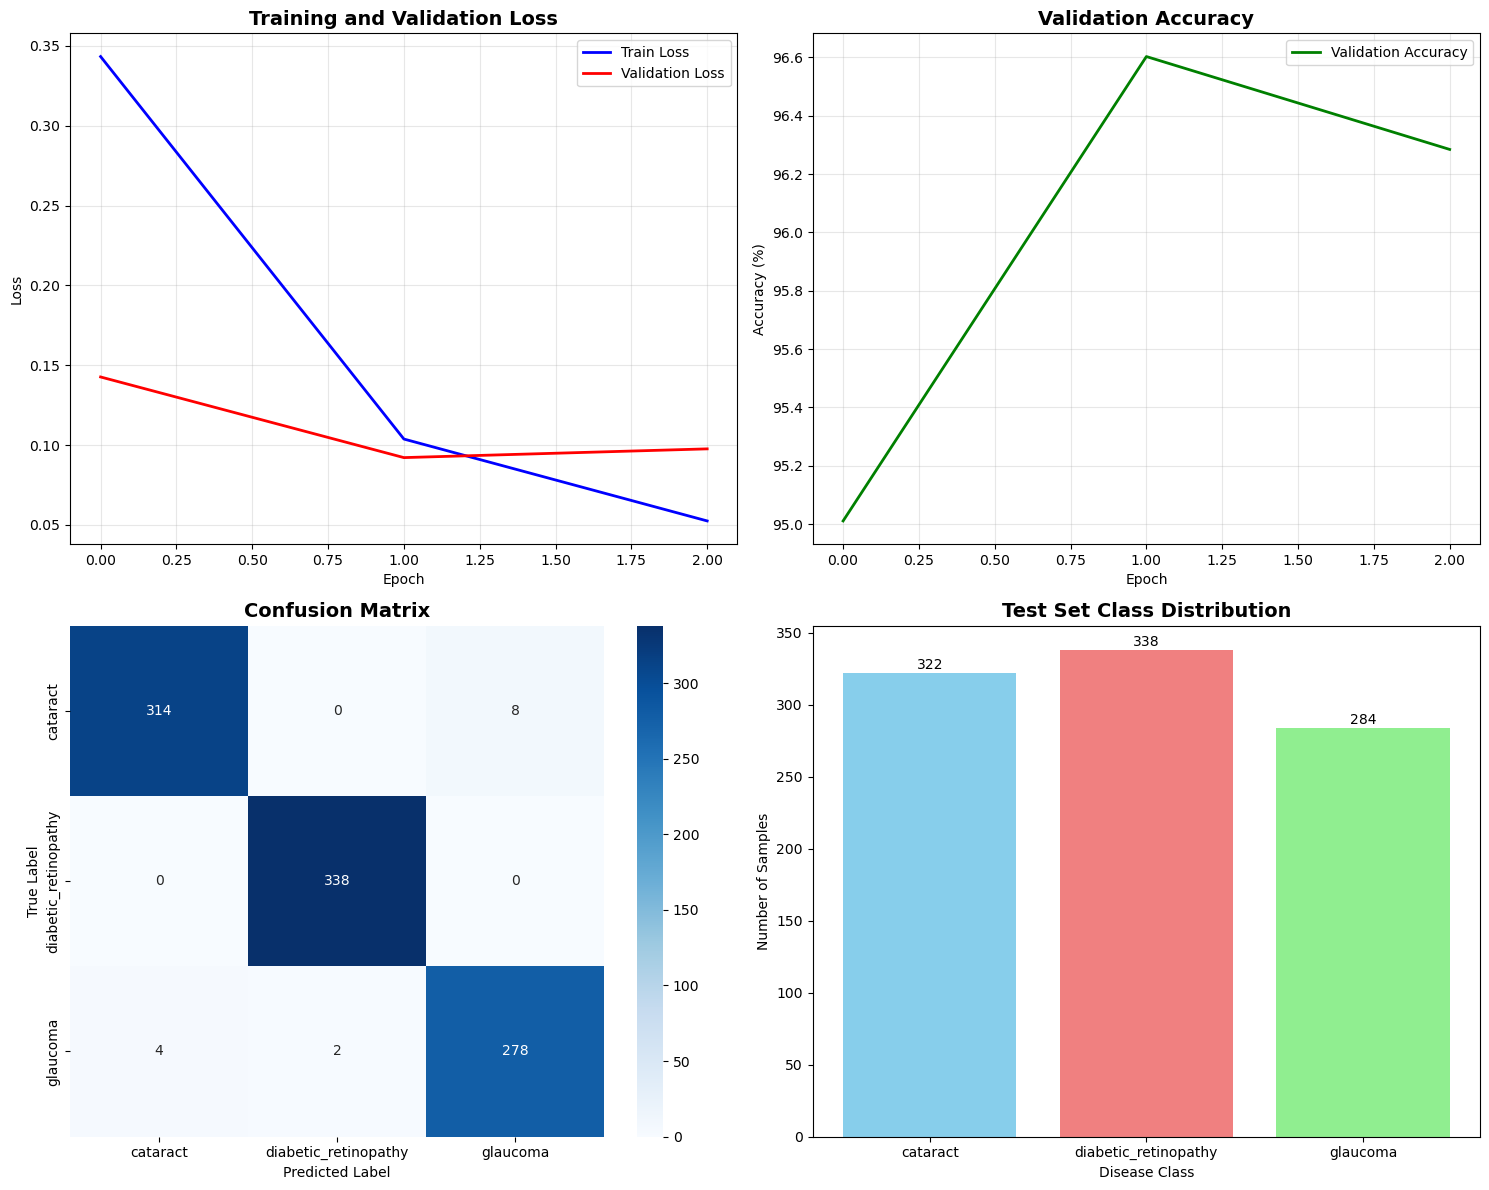


✅ Training completed successfully!
Best model saved as 'best_resnet50_multi_disease_model.pth'
Final test accuracy: 98.52%


In [23]:
# --- Test evaluation ---
model.eval()
test_preds = []
test_labels = []
correct_test = 0
total_test = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct_test / total_test

# Per-class test accuracy
per_class_test_correct = {i: 0 for i in range(num_classes)}
per_class_test_total = {i: 0 for i in range(num_classes)}

for pred, true in zip(test_preds, test_labels):
    per_class_test_total[true] += 1
    if pred == true:
        per_class_test_correct[true] += 1

per_class_test_acc = {i: (per_class_test_correct[i] / per_class_test_total[i] * 100) if per_class_test_total[i] > 0 else 0 
                     for i in range(num_classes)}

print(f"\n🎯 FINAL TEST RESULTS")
print("="*50)
print(f"Overall Test Accuracy: {test_acc:.2f}%")
print(f"\nPer-class Test Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {per_class_test_acc[i]:.2f}%")

# Detailed classification report
print(f"\n📊 DETAILED CLASSIFICATION REPORT")
print("="*50)
report = classification_report(test_labels, test_preds, target_names=class_names, digits=4)
print(report)

# Calculate additional metrics
for i, class_name in enumerate(class_names):
    y_true_binary = [1 if label == i else 0 for label in test_labels]
    y_pred_binary = [1 if pred == i else 0 for pred in test_preds]
    
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    
    print(f"\n{class_name} Detailed Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# Plot training curves and confusion matrix
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Training and validation loss
ax1.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation accuracy
ax2.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
           xticklabels=class_names, yticklabels=class_names)
ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax3.set_xlabel('Predicted Label')
ax3.set_ylabel('True Label')

# Class distribution
class_counts = [test_labels.count(i) for i in range(num_classes)]
ax4.bar(class_names, class_counts, color=['skyblue', 'lightcoral', 'lightgreen'])
ax4.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Disease Class')
ax4.set_ylabel('Number of Samples')

# Add count labels on bars
for i, count in enumerate(class_counts):
    ax4.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n✅ Training completed successfully!")
print(f"Best model saved as 'best_resnet50_multi_disease_model.pth'")
print(f"Final test accuracy: {test_acc:.2f}%")